# Browse Runs

Interactive notebook for monitoring training progress and visualizing runs.

**Usage:** Re-run this notebook to get the latest training status.

**CLI commands** (from `tdmpc2/` directory):
```bash
python -m discover status     # Quick status overview
python -m discover running    # Currently running tasks
python -m discover tasks      # All tasks with progress (225 official tasks)
python -m discover tasks --all  # Include non-official tasks (smoke-test, etc.)
python -m discover restart    # Show restart commands for stalled tasks (dry-run; add --submit to run)
python -m discover restart --submit-all-incomplete  # Submit ALL non-complete tasks (ignores heartbeat/W&B)
python -m discover --help     # All available commands
```

## Setup

In [1]:
from pathlib import Path
import sys

# Ensure repo root is importable
ROOT = Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Change to ROOT for CLI commands
%cd {ROOT}

/home/projects/dharel/nadavt/repos/newt/tdmpc2


/home/projects/dharel/nadavt/.conda/envs/newt/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd

# Notebook display defaults: don't truncate long outputs with `...`
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
np.set_printoptions(threshold=np.inf)

In [3]:
# Import the discover API
from discover import load_df
from discover.config import get_target_step
from discover.plots import training_overview, plot_max_steps, progress_by_domain

TARGET_STEP = get_target_step()
print(f"TARGET_STEP: {TARGET_STEP:,}")

TARGET_STEP: 5,000,000


## Load Runs Data

In [4]:
# load_df() loads merged runs from local logs + wandb (uses cache by default)
# Set refresh=True to force re-fetch from sources
df_all = load_df(refresh=True)
print(f"Loaded {len(df_all)} runs")

Scanning local logs (/home/projects/dharel/nadavt/repos/newt/tdmpc2/logs)...
  2433 local runs found        
/home/projects/dharel/nadavt/.conda/envs/newt/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/projects/dharel/nadavt/.conda/envs/newt/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-s

Loaded 2433 runs


  Fetched 1 run details in 0.0s (355/s)


## Training Progress Overview

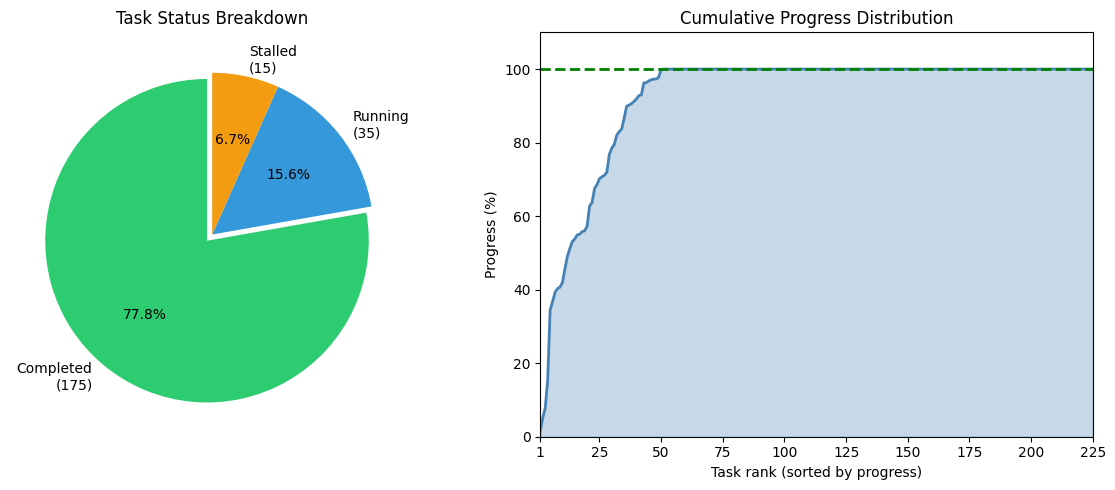

                 TRAINING PROGRESS SUMMARY                  
  Total tasks:            225  (from tasks.json)
  Target step:         5,000,000
------------------------------------------------------------
  🟢 ✅ Completed:         175 (77.8%)
  🔵 🏃 Running:            35 (15.6%)  <- active (see discover.liveness)
  🟠 ⏸️  Stalled:            15 (6.7%)  <- needs restart
  🔴 ❌ Not Started:         0 (0.0%)
------------------------------------------------------------
  Average progress:      92.6%
  Median progress:      100.0%
  Min steps:           84,648
  Max steps:           5,000,002


In [5]:
# training_overview: pie chart + summary stats
# Categories are computed via the central liveness + aggregation logic in `discover.liveness`.
training_overview(df_all, target_step=TARGET_STEP)

## Currently Running / Needs Restart (CLI)


In [6]:
# CLI: list all tasks with progress, running count, and status
# Options: --format json|csv, --not-started, --stalled, --running, --completed
!python -m discover tasks

                                        ALL TASKS                                         
Task                                            Progress     Max Step      Video  Eval?   HB   WB          Status
------------------------------------------------------------------------------------------
   ms-pick-cup                                     1.7%       84,648     75,648           2    0       🔵 running
   ms-pick-rubiks-cube                             5.1%      256,246    248,448           3    0       🔵 running
   ms-pick-soccer-ball                             7.8%      391,496    383,048    Yes    3    0       🔵 running
   ms-pick-golf-ball                              15.3%      766,646    700,000           1    0       🔵 running
   rd-push-blue                                   34.5%    1,723,526  1,700,000           1    0       🔵 running
   pygame-rocket-collect                          36.8%    1,841,552  1,800,000           1    0       🔵 running
   pygame-reacher-var1    

In [7]:
# CLI: progress aggregated by domain prefix (walker-*, mw-*, etc.)
!python -m discover domains

                               PROGRESS BY DOMAIN                               
Domain                  Tasks   Complete   Avg Progress   Completion %
--------------------------------------------------------------------------------
acrobot                     1          1         100.0%         100.0%
hopper                      3          3         100.0%         100.0%
spinner                     6          6         100.0%         100.0%
reacher                     4          4         100.0%         100.0%
quadruped                   2          2         100.0%         100.0%
pendulum                    2          2         100.0%         100.0%
mujoco                      6          6         100.0%         100.0%
jumper                      1          1         100.0%         100.0%
lunarlander                 3          3         100.0%         100.0%
giraffe                     1          1         100.0%         100.0%
fish                        1          1         100.0%  

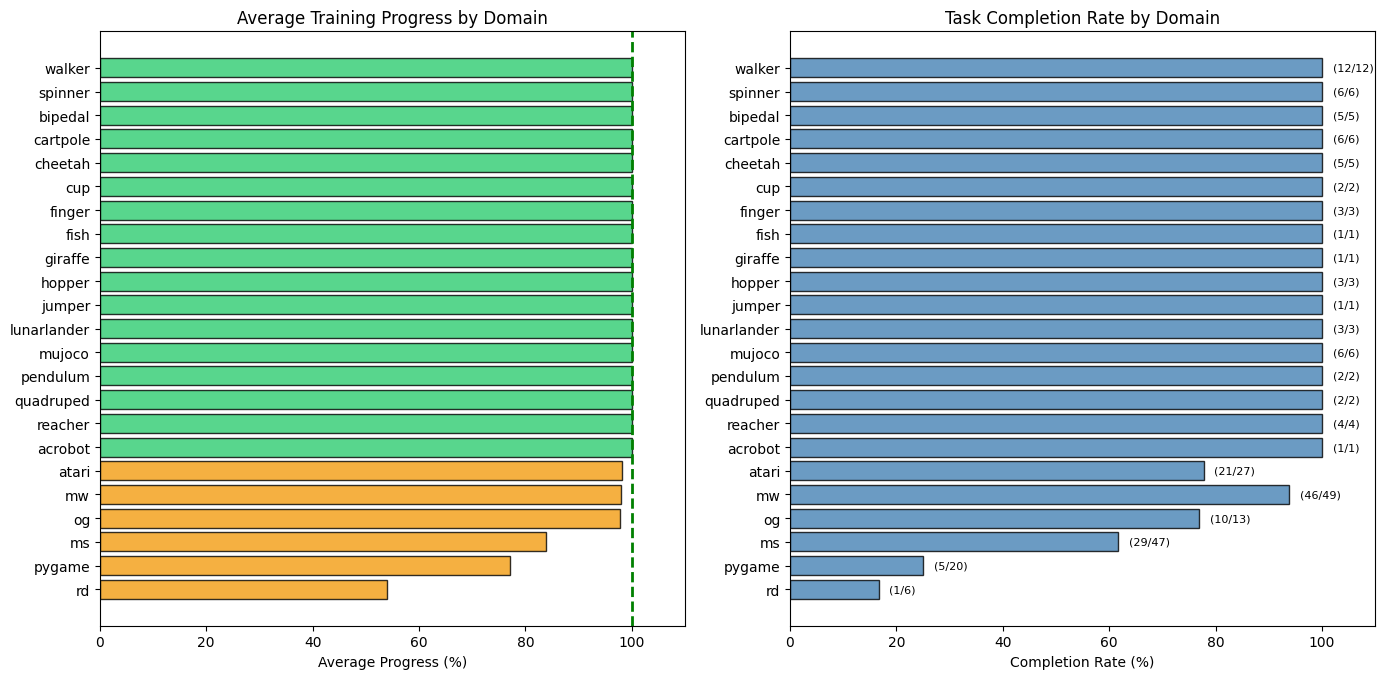


Domain Summary:
--------------------------------------------------------------------------------
Domain                  Tasks   Complete   Avg Progress   Completion %
--------------------------------------------------------------------------------
lunarlander                 3          3         100.0%         100.0%
jumper                      1          1         100.0%         100.0%
spinner                     6          6         100.0%         100.0%
bipedal                     5          5         100.0%         100.0%
cartpole                    6          6         100.0%         100.0%
cheetah                     5          5         100.0%         100.0%
cup                         2          2         100.0%         100.0%
finger                      3          3         100.0%         100.0%
fish                        1          1         100.0%         100.0%
giraffe                     1          1         100.0%         100.0%
hopper                      3          3

In [8]:
# progress_by_domain: visualization of domain-level progress
progress_by_domain(df_all, target_step=TARGET_STEP)

## 4. Currently Running


In [9]:
# CLI: shows tasks that are currently considered active by `discover.liveness`.
# (Any source-specific signals shown are derived from that central logic.)
!python -m discover running

                         RUNNING RUNS SUMMARY                         
  Active runs (WB):               0
  Active runs (HB):              50
  Stale local 'running':       1250  ⚠️  (local-only)
  Tasks with running runs:       37
  Tasks needing restart:         13  ⚠️  (incomplete, no active signal)
  Tasks with stale runs:          0  🔄 (>1 wandb run, from resume)

🏃 CURRENTLY RUNNING TASKS (37 tasks):
   wandb running runs: 0 | alive heartbeats: 50
----------------------------------------------------------------------
Task                                      Wandb     HB     Progress     Max Step
----------------------------------------------------------------------
   ms-pick-cup                                0      2        1.7%       84,998
   ms-pick-rubiks-cube                        0      3        5.1%      256,388
   ms-pick-soccer-ball                        0      3        7.8%      391,640
   ms-pick-golf-ball                          0      1       15.3%      766,79

## 5. Needs Restart

In [10]:
# CLI: shows bsub commands for tasks that need attention, according to `discover.liveness`.
# Add --submit to actually execute the bsub commands
!python -m discover restart

                         RUNNING RUNS SUMMARY                         
  Active runs (WB):               0
  Active runs (HB):              53
  Stale local 'running':       1250  ⚠️  (local-only)
  Tasks with running runs:       38
  Tasks needing restart:         13  ⚠️  (incomplete, no active signal)
  Tasks with stale runs:          0  🔄 (>1 wandb run, from resume)

⚠️  TASKS NEEDING RESTART (13 tasks, no active signal; see discover.liveness):
----------------------------------------------------------------------
Task                                         Progress        Max Step     HB  Wandb
----------------------------------------------------------------------
   atari-chopper-command                       99.9%       4,996,558      0      0
   ms-pick-knife                               97.3%       4,863,198      0      0
   pygame-reacher-hard                         97.3%       4,864,784      0      0
   ms-pick-tennis-ball                         93.0%       4,648,248     

In [15]:
# Submit all non-completed tasks (ignores heartbeat/W&B active-signal checks; may re-submit running jobs)
!python -m discover restart --submit-all-incomplete


⚠️  ALL INCOMPLETE TASKS (50 tasks; ignores active signals):


                                RESTART COMMANDS                                

# long-gpu (exclusive, 48h) (6 tasks)
# Tasks: atari-chopper-command, atari-crazy-climber, atari-double-dunk, atari-battle-zone, atari-beamrider ... and 1 more
bsub -J "newt-expert[6,7,8,10,11,12]" \
  -q long-gpu \
  -n 1 -gpu "num=1:mode=exclusive_process" -R "rusage[mem=32GB,tmp=10240]" -W 48:00 -r \
  -o /home/projects/dharel/nadavt/repos/newt/tdmpc2/logs/lsf/newt-expert.%J.%I.log \
  -e /home/projects/dharel/nadavt/repos/newt/tdmpc2/logs/lsf/newt-expert.%J.%I.log \
  -u "$USER" -N \
  -app nvidia-gpu \
  -env "LSB_CONTAINER_IMAGE=ops:5000/newt:1.0.2" \
  /home/projects/dharel/nadavt/repos/newt/tdmpc2/jobs/run_expert_task.sh

# long-gpu (shared/ManiSkill, 48h) (18 tasks)
# Tasks: ms-pick-orange, ms-pick-knife, ms-pick-tennis-ball, ms-pick-spoon, ms-pick-screwdriver ... and 13 more
bsub -J "newt-expert[71,77,79,80,81,83,84,85,86,88,89,94,9

## 6. Eval Status

In [12]:
# # CLI: list tasks ready for eval (≥50% trained) and their video status
# # Use 'python -m discover eval submit --submit' to generate and submit eval jobs
# !python -m discover eval list --min-progress 0

In [ ]:
# dry-run by default, add --submit to actually submit
!python -m discover eval submit --submit --min-progress 0

Checking for videos in 225 tasks...
                      TASKS READY FOR EVALUATION (checkpoint vs video)                      

Total tasks at ≥0%: 225
  ✅ Video up-to-date: 212
  ⚠️  Video stale:     13
  ❌ No video:         0
  🧪 Needs eval:       13

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Task                                                  Ckpt        Video   Progress Needs Eval
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  acrobot-swingup                                5,000,000    5,000,000     100.0%           
  atari-alien                                    5,000,000    5,000,000     100.0%           
  atari-assault                                  5,000,000    5,000,000     100.0%           
  atari-asterix                                  5,000,000    5,000,000     100.0%           
  atari-atlantis                

## 7. Collect Videos

In [17]:
# CLI: collect videos from trained tasks into videos_for_presentation/
# Options: --min-progress 0.5, --symlink (instead of copying), --output <dir>
# Then: rsync -avz server:tdmpc2/discover/videos_for_presentation/ ./videos/
!python -m discover videos collect --min-progress 0

Checking for videos in 225 tasks...
                       VIDEOS COLLECTED FOR PRESENTATION                        

📁 Output directory: /home/projects/dharel/nadavt/repos/newt/tdmpc2/discover/videos_for_presentation
   Total videos: 225
   Method: copies
   ✨ New videos: 0
   🔄 Updated videos: 13
   🗑️  Pruned old videos: 13
   ⚠️  Newer checkpoint exists w/o video (needs eval): 1
   ❌ No videos at all (needs eval): 0

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Task                                                  Ckpt        Video   Progress Needs Eval   New    Upd     Pruned
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  acrobot-swingup                                5,000,000    5,000,000     100.0%                                   
  atari-alien                                    5,000,000    5,000,000     100.0%                         